In [4]:
import numpy as np
import pandas as pd
import datetime
import holidays

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
def seed_everything(seed: int = 24):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(24)

In [116]:
df = pd.read_csv('train.csv')
test = pd.read_csv('submission.csv')
df.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

# EDA & 전처리

In [120]:
# 결측치 비율
def missing_value_ratio(df, column_name):
    total_rows = len(df)
    missing_values = df[column_name].isnull().sum()
    missing_ratio = (missing_values / total_rows) * 100
    return missing_ratio

# text feature
- lead_desc_length
- inquiry_type
- expected_timeline

## lead_desc_length 고객이 작성한 Lead Description 텍스트 총 길이
- 길수록 전환가능성이 높지 않을까?

In [121]:
missing_value_ratio(df, 'lead_desc_length'), missing_value_ratio(test, 'lead_desc_length')

(0.0, 0.0)

<AxesSubplot:xlabel='is_converted', ylabel='lead_desc_length'>

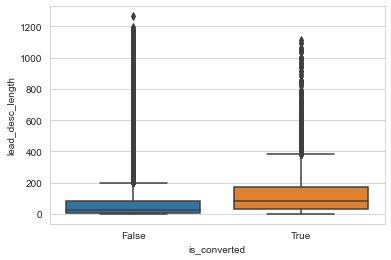

In [122]:
sns.boxplot(data =df, y='lead_desc_length', x='is_converted')

<AxesSubplot:xlabel='lead_desc_length', ylabel='Density'>

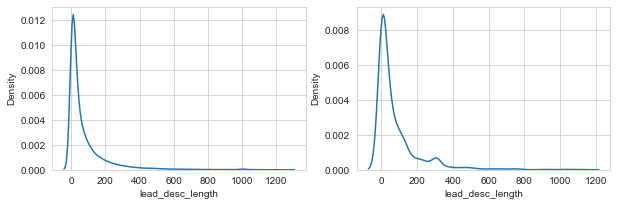

In [123]:
#분포 확인
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.kdeplot(df['lead_desc_length'])

plt.subplot(1, 2, 2)
sns.kdeplot(test['lead_desc_length'])

## inquiry_type 고객의 문의 유형

In [124]:
missing_value_ratio(df, 'inquiry_type'), missing_value_ratio(test, 'inquiry_type')

(1.5868733030911144, 24.51147789793208)

In [125]:
len(df['inquiry_type'].unique())

72

In [126]:
df['inquiry_type'].unique()

array(['Quotation or purchase consultation', 'Product Information',
       'Quotation or Purchase Consultation', 'Other',
       'Usage or technical consultation', 'Trainings', 'Services',
       'Sales Inquiry', 'Etc.', 'Technical Support',
       'Usage or Technical Consultation', 'Technical Consultation',
       'Request for Partnership', nan, 'sales', 'technical',
       'usage or technical consultation',
       'usage_or_technical_consultation', 'other',
       'quotation_or_purchase_consultation', 'other_', 'Request a Demo',
       'Request for Distributorship', 'Request for quotation or purchase',
       'Request for technical consulting', '(Select ID_Needs)',
       'One Quick:Flex', 'AIO', 'Needs', 'Purchase',
       'technical_consultation', 'Customer Suggestions', 'Event Inquiry',
       'Others', 'OEM/ODM Request', 'Hospital TV', 'others',
       'i want to know the details about it', 'EDUCATIONAL EQUIPMENTS',
       'Digital platform', 'TV interactive', 'teach',
       'Di

In [127]:
test['inquiry_type'].unique()

array([nan, 'Quotation or Purchase Consultation', 'Product Information',
       'Technical Consultation', 'Others', 'Request for Partnership',
       'Usage or Technical Consultation', 'Services',
       'Customer Suggestions', 'Request a Demo', 'Trainings', 'Other',
       'OEM/ODM Request', 'Media Inquiry', 'other_',
       'Request for Distributorship'], dtype=object)

In [128]:
def clean_inquiry_data(df):
    # 'inquiry_type'컬럼 소문자로 변경
    df['inquiry_type'] = df['inquiry_type'].str.lower()

    # 대소문자 및 언어는 영어로 통일
    mapping_dict = {
        'quotation or purchase consultation': 'quotation or purchase consultation',
        'product information': 'product information',
        'other': 'other',
        'usage or technical consultation': 'usage or technical consultation',
        'trainings': 'trainings',
        'services': 'services',
        'sales inquiry': 'sales inquiry',
        'etc.': 'etc.',
        'technical support': 'technical support',
        'request for partnership': 'request for partnership',
        'nan': 'nan',
        'request a demo': 'request a demo',
        'request for distributorship': 'request for distributorship',
        'request for quotation or purchase': 'request for quotation or purchase',
        '(select id_needs)': '(select id_needs)',
        'one quick:flex': 'one quick:flex',
        'aio': 'aio',
        'needs': 'needs',
        'purchase': 'purchase',
        'customer suggestions': 'customer suggestions',
        'event inquiry': 'event inquiry',
        'others': 'others',
        'oem/odm request': 'oem/odm request',
        'hospital tv': 'hospital tv',
        'i want to know the details about it': 'i want to know the details about it',
        'educational equipments': 'educational equipments',
        'digital platform': 'digital platform',
        'tv interactive': 'tv interactive',
        'teach': 'teach',
        'display textbook and photos': 'display textbook and photos',
        'high inch 86 / 98 or 110': 'high inch 86 / 98 or 110',
        'display product': 'display product',
        'first info and pricing': 'first info and pricing',
        'estoy buscando para ecuador este producto lg magnit micro led, para un cliente de 138 pulgadas, con envió marítimo.': 'lg magnit micro led inquiry',
        'hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil -ecuador.': 'interactive screens quotation',
        'window facing product': 'window facing product',
        'vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn': 'body temperature measurement device inquiry',
        'probeam precio': 'probeam pricing inquiry',
        'hotel tv products': 'hotel tv products',
        'pantallas interactivas para clinicas': 'interactive screens for clinics',
        'solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución one quick:': 'one quick solution quotation support',
        'intégrateur historique du george v': 'george v historical integrator',
        'idb': 'idb',
        'not specified': 'not specified',
        'for school': 'school inquiry',
        'media inquiry': 'media inquiry',
        'led signage': 'led signage inquiry',
        'standalone': 'standalone inquiry',
        'video wall': 'video wall inquiry',
        'toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung': 'technical information and pricing inquiry',
        'tôi cần tham khảo giá và giải pháp từ lg': 'lg product pricing and solutions inquiry',
        'preciso de um monitor médico para radiografia convencional e tomogrtafia.': 'medical monitor for conventional and tomography inquiry',
        'vrf': 'vrf inquiry',
        'evento_sdelestero': 'event inquiry'
    }

    # mapping_dict를 이용하여 값 변환
    df['inquiry_type'] = df['inquiry_type'].map(mapping_dict)

    group_mapping = {
        'quotation/purchase': ['quotation or purchase consultation', 'request for quotation or purchase', 'purchase or quotation', 'quotation_', 'purchase', 'interactive screens quotation'],
        'product inquiry': ['digital platform', 'media inquiry', 'probeam pricing inquiry', 'first info and pricing', 'probeam pricing inquiry', 'lg product pricing and solutions inquiry', 'led signage inquiry', 'standalone inquiry', 'video wall inquiry', 'hotel tv products','tv interactive', 'interactive screens for clinics', 'vrf inquiry', 'hospital tv', 'i want to know the details about it', 'lg magnit micro led inquiry', 'window facing product', 'body temperature measurement device inquiry', 'display textbook and photos', 'high inch 86 / 98 or 110', 'window facing product', 'lg magnit micro led inquiry', 'interactive screens quotation', 'window facing product', 'body temperature measurement device inquiry', 'sales inquiry', 'sales', 'sales inquiry', 'aio', 'needs', 'lg product pricing and solutions inquiry', 'medical monitor for conventional and tomography inquiry', 'product information', 'display product','one quick:flex'],
        'technical consultation': ['technical information and pricing inquiry', 'usage or technical consultation', 'technical support', 'usage or technical consultation', 'technical consultation', 'usage_or_technical_consultation', 'technical', 'technical_consultation'],
        
        'training and education': ['trainings', 'teach', 'educational equipments', 'school inquiry', 'idb'],
        'services': ['event inquiry', 'services'],
        'business partnership': ['request a demo', 'customer suggestions', 'request for partnership', 'request for distributorship', 'oem/odm request', 'george v historical integrator', 'idb'],
        'uncategorized': ['other', 'etc.', 'others', 'other_', 'not specified', '(select id_needs)', 'nan']

    }

    # inquiry_type 그루핑 함수 정의
    def categorize_inquiry(inquiry_type):
        for category, inquiries in group_mapping.items():
            if inquiry_type in inquiries:
                return category
        return 'uncategorized'

    df['inquiry_category'] = df['inquiry_type'].apply(categorize_inquiry)

    return df


In [129]:
df = clean_inquiry_data(df)
df['inquiry_category'].value_counts()

quotation/purchase        42279
product inquiry           11247
uncategorized              3039
technical consultation     1292
business partnership        574
training and education      447
services                    421
Name: inquiry_category, dtype: int64

In [130]:
test = clean_inquiry_data(test)
test['inquiry_category'].value_counts()

quotation/purchase        3465
uncategorized             1549
business partnership        80
product inquiry             70
technical consultation      52
services                    34
training and education      21
Name: inquiry_category, dtype: int64

<Figure size 2160x1080 with 0 Axes>

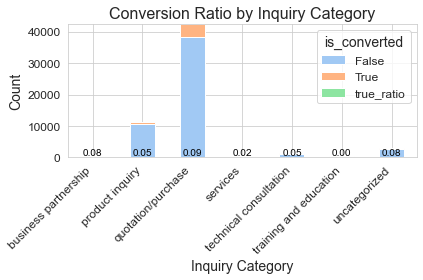

In [131]:
# 고객의 문의 유형별 전환비율

category_counts = df.groupby(['inquiry_category', 'is_converted']).size().unstack(fill_value=0)

# 'is_converted'가 True인 비율 계산
category_counts['true_ratio'] = category_counts[True] / (category_counts[True] + category_counts[False])

# 시각화
plt.figure(figsize=(30, 15))

# seaborn 스타일 설정
sns.set_style("whitegrid")

# 색상 팔레트 설정
colors = sns.color_palette("pastel")

# 그래프 생성
ax = category_counts.plot(kind='bar', stacked=True, color=colors)

# 텍스트 스타일 조정
for i, value in enumerate(category_counts['true_ratio']):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', color='black')

# 그래프 제목 및 축 라벨 스타일 조정
plt.title('Conversion Ratio by Inquiry Category', fontsize=16)
plt.xlabel('Inquiry Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='is_converted', fontsize=12, title_fontsize='14', loc='upper right')

# 그래프 출력
plt.tight_layout()
plt.show()

# expected_timeline

In [132]:
missing_value_ratio(df, 'expected_timeline'), missing_value_ratio(test, 'expected_timeline')

(52.04640887704684, 45.68393094289508)

In [133]:
df['expected_timeline'].unique()

array(['less than 3 months', nan, '3 months ~ 6 months',
       '9 months ~ 1 year', 'more than a year', '6 months ~ 9 months',
       'quote has been sent to customer.',
       'partner was exploring on eol model for some requiremeent. no designated sales or closure expected hence closing in the system.',
       'already close in july purchse with rd',
       'client not interested in product.. receing call and not answering properly',
       'being followed up', 'being followed up.',
       'repeated inquiry from client. he was just inquiring but have not confimred on purchase. we have tried mulitple times but client is not interested in buying.',
       'update- 7th aug--demo given. customer will confirm next week',
       "tried to reach him multipe times from last 7 days but couldn't get through",
       'details send', 'discused with ankit in dehli',
       'requires detail for tender. no purchase requirement right now.',
       'partner is into static signages. he need to connec

In [134]:
def clean_expected_timeline(df):
    mapping_dict = {
        'less_than_3_months': 'less than 3 months',
        '3_months_~_6_months': '3 months ~ 6 months',
        '9_months_~_1_year': '9 months ~ 1 year',
        '6_months_~_9_months': '9 months ~ 1 year',
        'more_than_a_year': 'more than a year',
        'less then 6 months': '3 months ~ 6 months',
        'less than 5 months': '3 months ~ 6 months',
        'more then 3 months': '3 months ~ 6 months',
        'less than 3 months. customer not answered . to call back': 'less than 3 months',
        'one month': 'less than 3 months',
        'duplicate lead - il220100042906. less than 3 months': 'less than 3 months',
        '9 months - 1 year': '9 months ~ 1 year',
        'less than 3 months ,meeting with the customer for the more details and tentative boq will ne 32 and 43': 'less than 3 months',
        'less than 3 months- outdoor led requiment': 'less than 3 months'
    }

    valid_values = ['less than 3 months', '3 months ~ 6 months', '6 months ~ 9 months', '9 months ~ 1 year', 'more than a year']

    df['expected_timeline'] = df['expected_timeline'].replace(mapping_dict)
    df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in valid_values else 'unknown')

    return df

In [135]:
df = clean_expected_timeline(df)
df['expected_timeline'].value_counts()

unknown                31690
less than 3 months     17331
3 months ~ 6 months     5041
more than a year        3027
9 months ~ 1 year       1112
6 months ~ 9 months     1098
Name: expected_timeline, dtype: int64

In [136]:
test = clean_expected_timeline(test)
test['expected_timeline'].value_counts()

unknown                2408
less than 3 months     1734
3 months ~ 6 months     426
more than a year        272
9 months ~ 1 year       264
6 months ~ 9 months     167
Name: expected_timeline, dtype: int64

<Figure size 2160x1080 with 0 Axes>

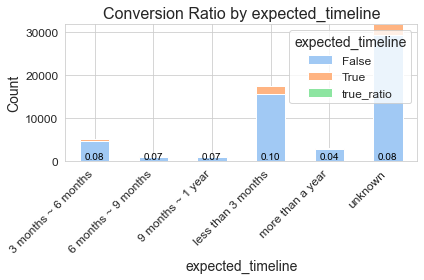

In [137]:
# 고객의 문의 유형별 전환비율

category_counts = df.groupby(['expected_timeline', 'is_converted']).size().unstack(fill_value=0)

# 'is_converted'가 True인 비율 계산
category_counts['true_ratio'] = category_counts[True] / (category_counts[True] + category_counts[False])

# 시각화
plt.figure(figsize=(30, 15))

# seaborn 스타일 설정
sns.set_style("whitegrid")

# 색상 팔레트 설정
colors = sns.color_palette("pastel")

# 그래프 생성
ax = category_counts.plot(kind='bar', stacked=True, color=colors)

# 텍스트 스타일 조정
for i, value in enumerate(category_counts['true_ratio']):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', color='black')

# 그래프 제목 및 축 라벨 스타일 조정
plt.title('Conversion Ratio by expected_timeline', fontsize=16)
plt.xlabel('expected_timeline', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='expected_timeline', fontsize=12, title_fontsize='14', loc='upper right')

# 그래프 출력
plt.tight_layout()
plt.show()

# product info
### product_category & product_subcategory

In [138]:
missing_value_ratio(df, 'product_category'), missing_value_ratio(test, 'product_category')

(32.671714531442355, 35.24947827736673)

In [139]:
len(df['product_category'].unique())

358

In [140]:
df['product_category'].unique()

array(['multi-split', 'single-split', 'vrf', 'chiller', 'etc.', 'rac',
       'teto ou cassete inverter', nan, 'software solution',
       'all lg vrf systems', 'ventilation',
       'a thermodynamic water heater', 'residential air conditioner',
       'outros', 'heating', 'multi v5 vrf', 'split tunggal',
       'multi inverter', 'חימום', 'standard signage',
       'high brightness signage', 'interactive signage',
       'video wall signage', 'led signage', 'hotel tv',
       'signage care solution', 'oled signage', 'idb', 'video wall',
       'one:quick series', 'commercial tv', 'lg one:quick',
       'special signage', 'other', 'accessories', 'commercial display',
       'interactive digital board', 'standard', 'uhd signage',
       'smart tv signage', 'lg one:quick series', 'pro:centric', 'ur640',
       'ur640s', 'webos', 'signage care solutions', 'aio | one quick',
       'high brightness', 'hospital tv', 'digital signage', 'monitor',
       'pc', 'laptop', 'projector', 'cloud dev

In [141]:
test['product_category'].unique()

array([nan, 'hospital tv', 'led signage', 'cloud device',
       'standard signage', 'interactive signage', 'multi-split',
       'video wall signage', 'vrf', 'monitor', 'etc.', 'heating',
       'ventilation', 'control', 'single-split',
       'high brightness signage', 'chiller', 'oled signage',
       'special signage', 'hotel tv', 'projector', 'medical display',
       'signage care solution', 'ess', 'laptop',
       'interactive digital board', 'pro:centric', 'software solution',
       'others', 'one:quick series', 'webos', 'notebook', 'accessories',
       'other'], dtype=object)

In [142]:
def categorize_product_categories(df):

    rules = {
        'medical': 'medical|radiology|surgical|healthcare',
        'display and signage': 'display|signage|tv|led|oled|projector|vide|quick|monitor|pc|series|webos|virtual production|ur640|high brightness|idb|43us660h0sd.awz|board|28mq780|32lq621cbsb.awz|互動式顯示屏|32lq621cbsb.awz|特別顯示屏|definir|醫院電視|軟體|retaildigital|高亮度顯示屏|magnit|uh|aio|酒店電視|פיצול מרובה|3|4|0|5|allinone|leadallin|標準顯示屏|standalone|hospitality',
        'mobile and portable devices': 'notebook|accessories|outros|cloud|mobile|laptop|otros|control|אחר|unitario|ฯลฯ|آخر|lainnya|parts|autre|khác',
        'air conditioning and heating': 'air condition|split|chiller|heating|heater|air|vrf|rac|teto ou cassete inverter|ventilation|ar condicionado residencial|multi|pompy ciepła|ac|multi v water 5|isıtma|calefacción|single package|حلول التدفئة|pendingin|réfrigérant|تكييف وتبريد|تكييفات|مبرد|מזגנים|تكييف وتبريد|חימום|điều hòa|aquecimento|vb.|เครื่องปรับอากาศเผื่อที่อยู่อาศัย|ahu|scroll compressor|résidentiel',
        'software and services': 'software|service|customer|technical|sales|centric|sac|id',
        'solar system': 'solar|energy|ess',
        'home appliances': 'washing|machine|vacuum|styler|home|beauty|cooking|built|robot|refrigerator|soğutucu',
        'others': 'other|error|not specified|inne|etc'
    }
    
    for category, pattern in rules.items():
        mask = df['product_category'].str.contains(pattern, case=False, na=False)
        df.loc[mask, 'product_category'] = category
    
    return df

In [143]:
df = categorize_product_categories(df)
df['product_category'].value_counts()

display and signage             20088
air conditioning and heating    15707
others                           2053
medical                          1011
mobile and portable devices       616
software and services             398
solar system                       34
home appliances                    14
standard                            4
Name: product_category, dtype: int64

In [144]:
test = categorize_product_categories(test)
test['product_category'].value_counts()

air conditioning and heating    1646
display and signage             1452
others                           207
mobile and portable devices       51
medical                           32
software and services             21
solar system                       4
Name: product_category, dtype: int64

In [145]:
# 잘 mapping되었는지 확인
product_notna = df[df['product_category'].notna() & df['product_subcategory'].notna()]
product_notna[['product_category', 'product_subcategory']]

,product_category,product_subcategory
388,display and signage,New High Haze UHD Standard Signage
389,display and signage,Window Facing Display
390,display and signage,LG CreateBoard
391,display and signage,UR640S Series
392,display and signage,TR3DJ Series
...,...,...
59151,display and signage,LG LED Bloc
59152,display and signage,LG LED Bloc
59153,display and signage,Outdoor Display
59154,display and signage,Outdoor Display


# LG
- business_unit MQL 요청 상품에 대응되는 사업부
- response_corporate 담당 자사 법인명
- lead_owner 영업 담당자 이름

In [146]:
df['business_area'].unique()

array(['corporate / office', nan, 'education', 'hotel & accommodation',
       'hospital & health care', 'special purpose', 'residential (home)',
       'government department', 'retail', 'factory',
       'power plant / renewable energy', 'transportation',
       'public facility'], dtype=object)

# Customer
- business_area
- business_subarea

In [147]:
missing_value_ratio(df, 'business_area')

68.94214067690855

In [148]:
df['business_area'].unique()

array(['corporate / office', nan, 'education', 'hotel & accommodation',
       'hospital & health care', 'special purpose', 'residential (home)',
       'government department', 'retail', 'factory',
       'power plant / renewable energy', 'transportation',
       'public facility'], dtype=object)

In [149]:
df.loc[df['it_strategic_ver']==1.0, 'business_unit'].unique()

array(['IT'], dtype=object)

In [150]:
df['business_unit'].unique()

array(['AS', 'ID', 'IT', 'Solution', 'CM'], dtype=object)

# ver_pro
- 특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치

In [160]:
df.loc[df['ver_pro']==1.0, 'product_category'].unique()

array(['display and signage'], dtype=object)

# ver_win_ratio_per_bu

In [158]:
df[['ver_win_ratio_per_bu', 'business_unit']]

,ver_win_ratio_per_bu,business_unit
0,0.026846,AS
1,0.026846,AS
2,0.026846,AS
3,0.026846,AS
4,0.026846,AS
...,...,...
59294,0.028777,AS
59295,0.028777,AS
59296,0.028777,AS
59297,0.028777,AS


In [164]:
df.loc[df['customer_type']=='End-Customer', 'enterprise'].unique()

array(['Enterprise', 'SMB'], dtype=object)

In [166]:
test['customer_job'].unique()

array(['consulting', nan, 'information technology', 'sales',
       'engineering', 'marketing', 'purchasing', 'others', 'operations',
       'support', 'finance', 'business development', 'administrative',
       'education', 'product management',
       'program and project management', 'entrepreneurship',
       'community and social services', 'media and communication',
       'arts and design', 'healthcare services', 'accounting',
       'medical imaging specialist', 'clinical specialist', 'curation',
       'other', '3d/vfx art', 'legal', 'radiology professional',
       'military and protective services', 'real estate',
       'human resources', 'healthcare', 'electronics & telco',
       'quality assurance', 'pathologist', 'research',
       'surgery professional', 'film production', 'k12 school',
       'media and communications', 'medical solution provider'],
      dtype=object)